In [1]:
import sys
import copy
import random
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import scipy as scipy
import math
from time import gmtime, strftime
import cProfile
import timeit
import scipy.sparse as sps
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)
import numpy as np
from numpy.linalg import norm
import gzip
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from time import gmtime, strftime
import gzip
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import matplotlib
import matplotlib.patches as patches
import math
from scipy.stats.mstats import mquantiles
from random import randint
from sklearn.metrics.cluster import adjusted_rand_score
from scipy import stats
from matplotlib import cm
import pandas as pd
import math
import scipy
import collections
import sys
import gzip
import numpy as np
import os
import re
import gzip
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from time import gmtime, strftime
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import scipy.sparse as sps
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
from matplotlib import rc
from matplotlib import rcParams
from numpy import linalg as LA
%matplotlib inline

In [2]:
sys.path.append('/srv/gsfs0/projects/kundaje/users/oursu/code/3DChromatin_ReplicateQC/software/genomedisco/')
from genomedisco import processing, data_operations

Distance dependence curves for the simulations
===

GenomeDISCO | Fri Feb 16 02:13:02 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:02 2018 | processing: Loading interaction data from /ifs/scratch/oursu/data/chr21_datasets/GM12878_combined.chr21.RAWobserved.gz
GenomeDISCO | Fri Feb 16 02:13:03 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:03 2018 | processing: Loading interaction data from /ifs/scratch/oursu/data/chr21_datasets/HMEC.chr21.RAWobserved.gz
GenomeDISCO | Fri Feb 16 02:13:04 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:04 2018 | processing: Loading interaction data from /ifs/scratch/oursu/data/chr21_datasets/HUVEC.chr21.RAWobserved.gz
GenomeDISCO | Fri Feb 16 02:13:04 2018 | processing: Loading genomic reg

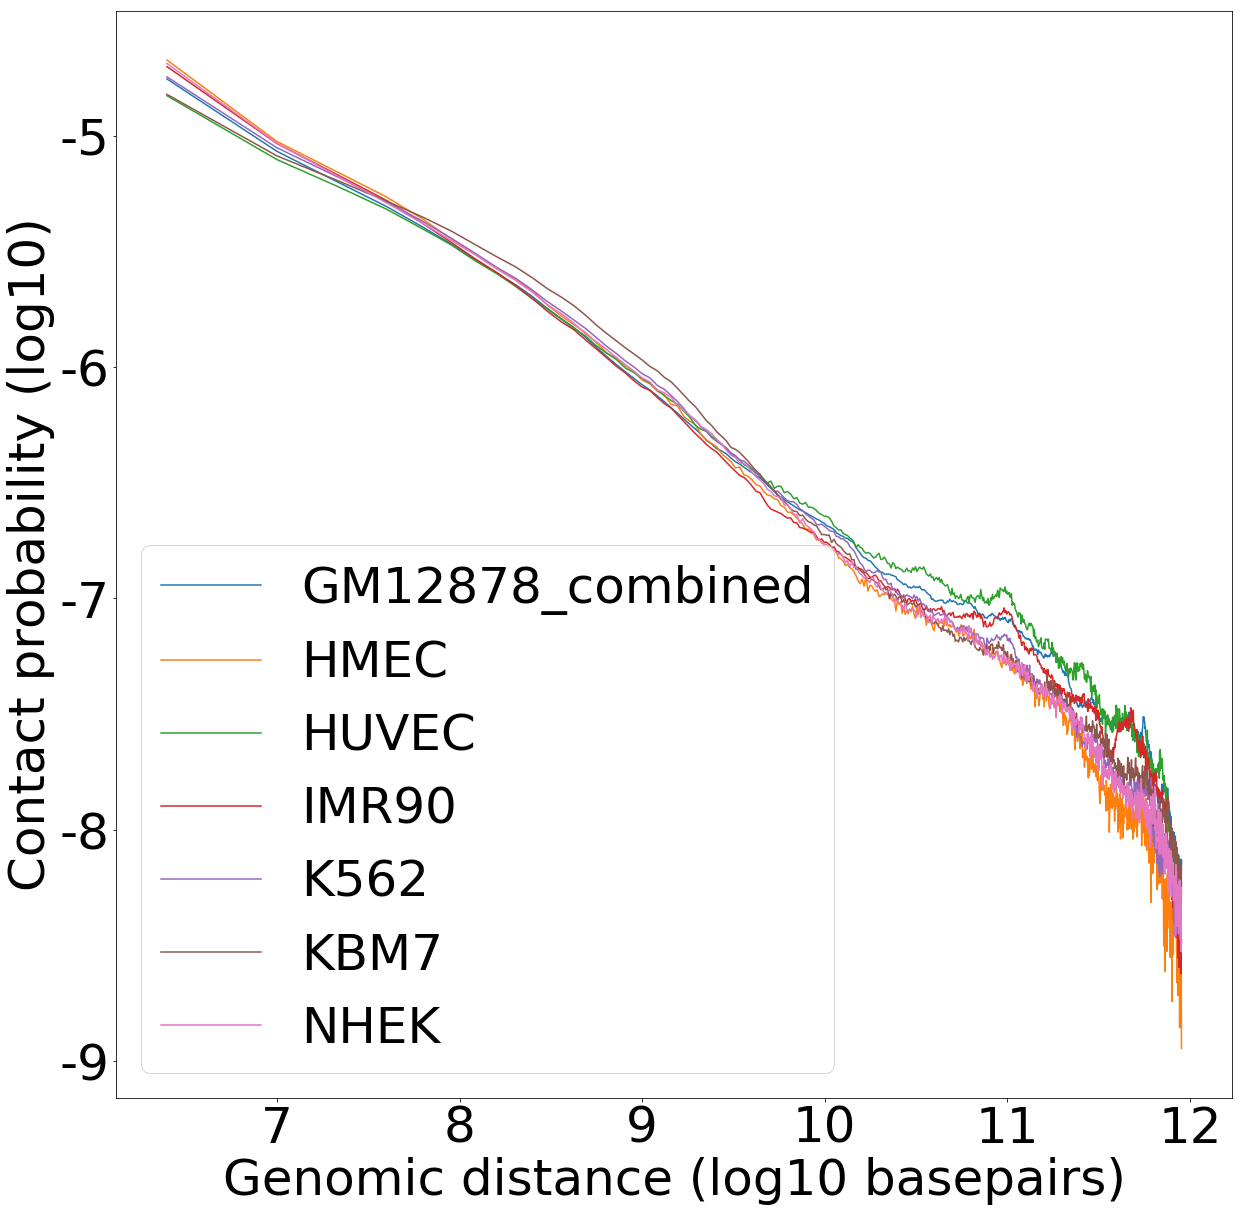

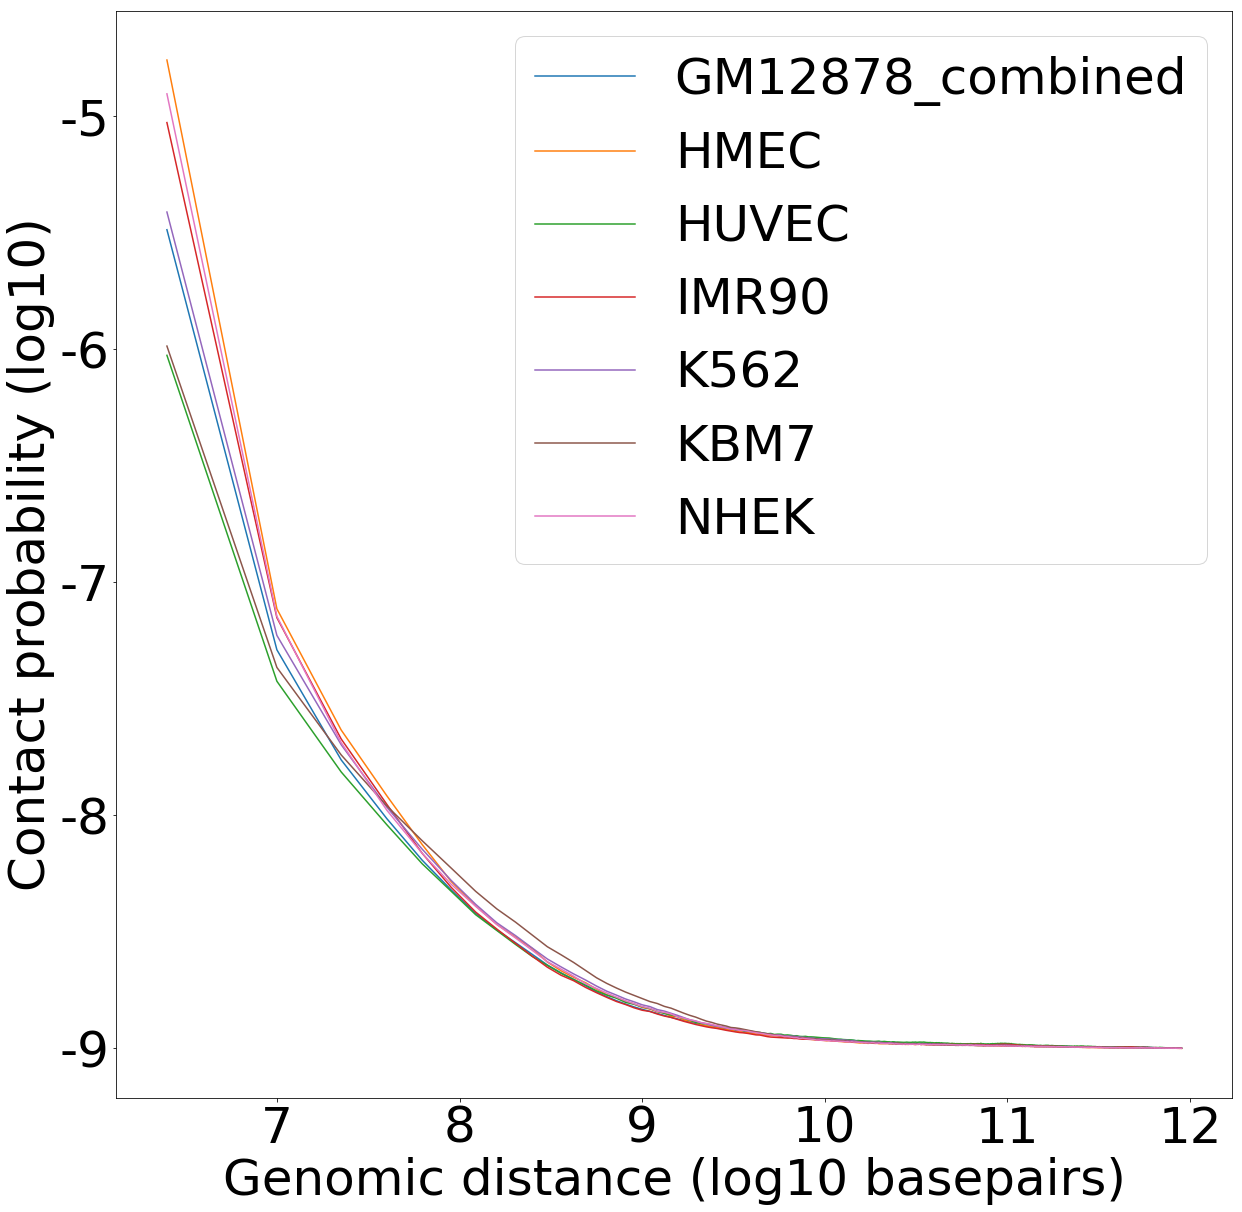

In [3]:
def get_distance_dep(m):
    m=m.toarray()
    assert m.shape[0]==m.shape[1]
    dcounts={}
    pcounts={}
    #get all distances we'll want to take into account
    for di in range(m.shape[0]):
        dcounts[di]=0
        pcounts[di]=0
    total_reads=m.sum()
    for i in range(m.shape[0]):
        dcounts[i]+=np.diagonal(m,i).sum()
    total_probs=0.0
    for di in range(m.shape[0]):
        pcounts[di]=1.0*dcounts[di]/((m.shape[0]-di)*total_reads)
        total_probs+=pcounts[di]
    return pcounts,total_probs

resolution=50000
s=1
e=600
dds={}
ddlist={}
x=[]

figwidth=20
figheight=20
fig, plots = plt.subplots(1,1)
fig.set_size_inches(figwidth,figheight)

for mname in ['GM12878_combined','HMEC','HUVEC','IMR90','K562','KBM7','NHEK']:
    node_file='/ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz'
    m1file='/ifs/scratch/oursu/data/chr21_datasets/'+mname+'.chr21.RAWobserved.gz'
    nodes,nodes_idx,blacklist_nodes=processing.read_nodes_from_bed(node_file,'NA')
    m=processing.construct_csr_matrix_from_data_and_nodes(m1file,nodes,blacklist_nodes,True)
    dds[mname],total_probs=get_distance_dep(m)
    ddlist[mname]=[]
    for i in range(m.shape[0]):
        x.append(i*resolution)
        ddlist[mname].append(dds[mname][i])
    y=ddlist[mname]
    plots.plot(np.log10(x[s:e]),np.log10(np.array(y[s:e])),label=mname)
    plots.legend(fontsize=50)
    plots.set_yticklabels(range(-10,-3),size=50)
    plots.set_xticklabels(range(6,15),size=50)
    plots.set_xlabel('Genomic distance (log10 basepairs)',fontsize=50)
    plots.set_ylabel('Contact probability (log10)',fontsize=50)
    
    
figwidth=20
figheight=20
fig, plots = plt.subplots(1,1)
fig.set_size_inches(figwidth,figheight)

for mname in ['GM12878_combined','HMEC','HUVEC','IMR90','K562','KBM7','NHEK']:
    node_file='/ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz'
    m1file='/ifs/scratch/oursu/data/chr21_datasets/'+mname+'.chr21.RAWobserved.gz'
    nodes,nodes_idx,blacklist_nodes=processing.read_nodes_from_bed(node_file,'NA')
    m=processing.construct_csr_matrix_from_data_and_nodes(m1file,nodes,blacklist_nodes,True)
    dds[mname],total_probs=get_distance_dep(m)
    ddlist[mname]=[]
    for i in range(m.shape[0]):
        x.append(i*resolution)
        ddlist[mname].append(dds[mname][i])
    y=ddlist[mname]
    plots.plot(np.log10(x[s:e]),np.array(y[s:e]),label=mname)
    plots.legend(fontsize=50)
    plots.set_yticklabels(range(-10,-3),size=50)
    plots.set_xticklabels(range(6,15),size=50)
    plots.set_xlabel('Genomic distance (log10 basepairs)',fontsize=50)
    plots.set_ylabel('Contact probability (log10)',fontsize=50)
    

In [4]:
#from https://stackoverflow.com/questions/15880133/jensen-shannon-divergence
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (scipy.stats.entropy(_P, _M) + scipy.stats.entropy(_Q, _M))

s=1
e=len(ddlist[mname])
ps=0.00000000000001
dddiff=open('/ifs/scratch/oursu/paper_2017-12-20/simulations/dd/dddiff.txt','w')
for mname1 in ['GM12878_combined','HMEC','HUVEC','IMR90','K562','KBM7','NHEK']:
    for mname2 in ['GM12878_combined','HMEC','HUVEC','IMR90','K562','KBM7','NHEK']:
        #d=abs(np.array(ddlist[mname1][s:e])-np.array(ddlist[mname2][s:e])).sum()
        p=1.0*np.array(np.array(ddlist[mname1])+ps)/np.array(np.array(ddlist[mname1])+ps).sum()
        q=1.0*np.array(np.array(ddlist[mname2])+ps)/np.array(np.array(ddlist[mname2])+ps).sum()
        js=JSD(p,q)
        dddiff.write(mname1+'\t'+mname2+'\t'+str(js)+'\n')
dddiff.close()

Distance dependence curves for the real data
===

GenomeDISCO | Fri Feb 16 02:13:40 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:40 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC001/HIC001.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:40 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:40 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC002/HIC002.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:41 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:41 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC003/HIC00

GenomeDISCO | Fri Feb 16 02:13:54 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:54 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC026/HIC026.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:55 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:55 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC027/HIC027.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:55 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:55 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC028/HIC02

/srv/gsfs0/projects/kundaje/users/oursu/code/anaconda2/mypython/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10


GenomeDISCO | Fri Feb 16 02:13:57 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:57 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC031/HIC031.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:57 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:57 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC032/HIC032.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:57 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:13:57 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC033/HIC03

GenomeDISCO | Fri Feb 16 02:14:08 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:14:08 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC056/HIC056.chr21.gz
GenomeDISCO | Fri Feb 16 02:14:08 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:14:08 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC057/HIC057.chr21.gz
GenomeDISCO | Fri Feb 16 02:14:09 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:14:09 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC058/HIC05

GenomeDISCO | Fri Feb 16 02:14:19 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:14:19 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC081/HIC081.chr21.gz
GenomeDISCO | Fri Feb 16 02:14:20 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:14:20 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC082/HIC082.chr21.gz


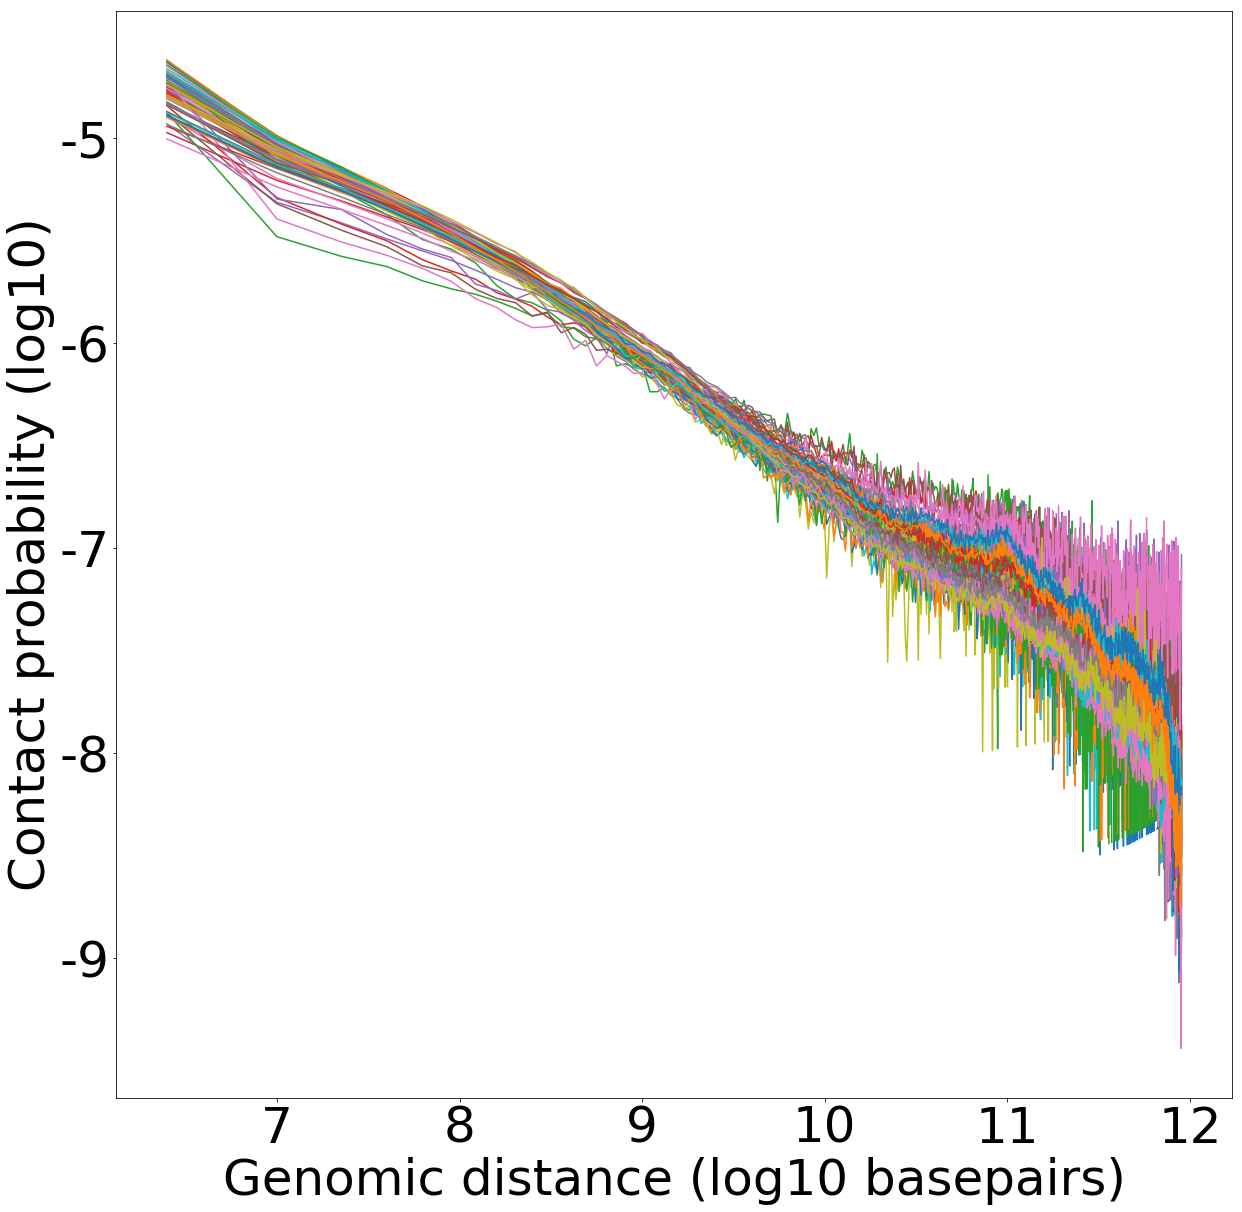

In [5]:
resolution=50000
s=1
e=600
dds={}
ddlist={}
x=[]

figwidth=20
figheight=20
fig, plots = plt.subplots(1,1)
fig.set_size_inches(figwidth,figheight)

for mname_number in range(83):
    if mname_number==0:
        continue
    node_file='/ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz'
    numlength=len(str(mname_number))
    if numlength==1:
        mname='HIC00'+str(mname_number)
    if numlength==2:
        mname='HIC0'+str(mname_number)
    m1file='/ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/'+mname+'/'+mname+'.chr21.gz'
    nodes,nodes_idx,blacklist_nodes=processing.read_nodes_from_bed(node_file,'NA')
    m=processing.construct_csr_matrix_from_data_and_nodes(m1file,nodes,blacklist_nodes,True)
    dds[mname],total_probs=get_distance_dep(m)
    ddlist[mname]=[]
    for i in range(m.shape[0]):
        x.append(i*resolution)
        ddlist[mname].append(dds[mname][i])
    y=ddlist[mname]
    plots.plot(np.log10(x[s:e]),np.log10(np.array(y[s:e])),label=mname)
    #plots.legend(fontsize=50)
    plots.set_yticklabels(range(-10,-3),size=50)
    plots.set_xticklabels(range(6,15),size=50)
    plots.set_xlabel('Genomic distance (log10 basepairs)',fontsize=50)
    plots.set_ylabel('Contact probability (log10)',fontsize=50)
    
    

In [6]:
s=1
e=len(ddlist[mname])
ps=0.00000000000001
dddiff=open('/ifs/scratch/oursu/paper_2017-12-20/results/rao/dd/dddiff.real.txt','w')
for mname_number1 in range(83):
    print mname_number1
    if mname_number1==0:
        continue
    numlength=len(str(mname_number1))
    if numlength==1:
        mname1='HIC00'+str(mname_number1)
    if numlength==2:
        mname1='HIC0'+str(mname_number1)
    for mname_number2 in range(83):
        if mname_number2==0:
            continue
        numlength=len(str(mname_number2))
        if numlength==1:
            mname2='HIC00'+str(mname_number2)
        if numlength==2:
            mname2='HIC0'+str(mname_number2)
        p=1.0*np.array(np.array(ddlist[mname1])+ps)/np.array(np.array(ddlist[mname1])+ps).sum()
        q=1.0*np.array(np.array(ddlist[mname2])+ps)/np.array(np.array(ddlist[mname2])+ps).sum()
        kl=scipy.stats.entropy(p,q)
        js=JSD(p,q)
        dddiff.write(mname1+'\t'+mname2+'\t'+str(js)+'\n')
dddiff.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82


GenomeDISCO | Fri Feb 16 02:14:41 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:14:41 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC070/HIC070.chr21.gz
GenomeDISCO | Fri Feb 16 02:14:42 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:14:42 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC072/HIC072.chr21.gz


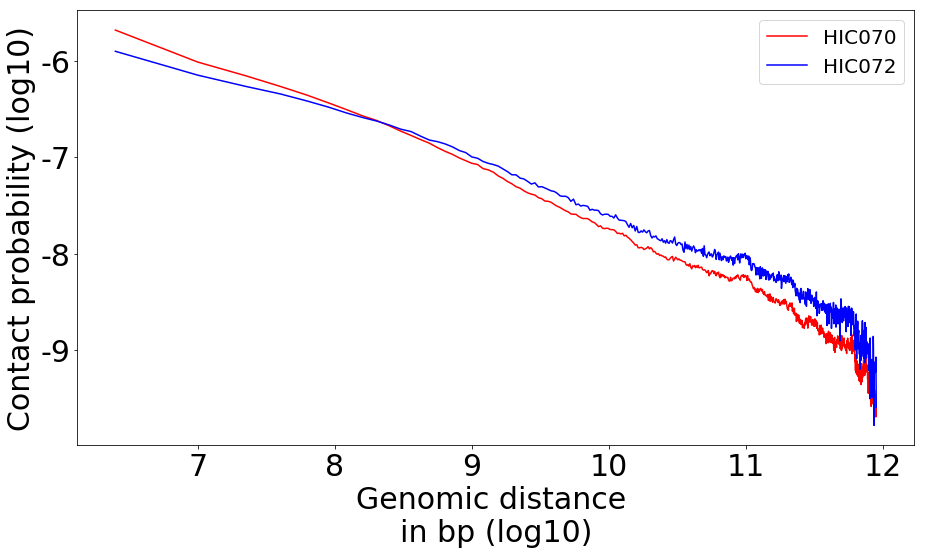

In [7]:
resolution=50000
s=1
e=600
dds={}
ddlist={}
x=[]

figwidth=15
figheight=8
fig, plots = plt.subplots(1,1)
fig.set_size_inches(figwidth,figheight)

for mname_number in [70,72]:
    if mname_number==0:
        continue
    node_file='/ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz'
    numlength=len(str(mname_number))
    if numlength==1:
        mname='HIC00'+str(mname_number)
    if numlength==2:
        mname='HIC0'+str(mname_number)
        
    if mname=='HIC070':
        c='red'
    else:
        c='blue'
    m1file='/ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/'+mname+'/'+mname+'.chr21.gz'
    nodes,nodes_idx,blacklist_nodes=processing.read_nodes_from_bed(node_file,'NA')
    m=processing.construct_csr_matrix_from_data_and_nodes(m1file,nodes,blacklist_nodes,True)
    dds[mname],total_probs=get_distance_dep(m)
    ddlist[mname]=[]
    for i in range(m.shape[0]):
        x.append(i*resolution)
        ddlist[mname].append(dds[mname][i])
    y=ddlist[mname]
    plots.plot(np.log10(x[s:e]),np.log10(np.array(y[s:e])),label=mname,color=c)
    plots.legend(fontsize=20)
    plots.set_yticklabels(range(-10,-3),size=30)
    plots.set_xticklabels(range(6,15),size=30)
    plots.set_xlabel('Genomic distance \nin bp (log10)',fontsize=30)
    plots.set_ylabel('Contact probability (log10)',fontsize=30)
    

GenomeDISCO | Fri Feb 16 02:25:31 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:25:31 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC014/HIC014.chr21.gz
GenomeDISCO | Fri Feb 16 02:25:31 2018 | processing: Loading genomic regions from /ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz
GenomeDISCO | Fri Feb 16 02:25:32 2018 | processing: Loading interaction data from /ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/HIC005/HIC005.chr21.gz


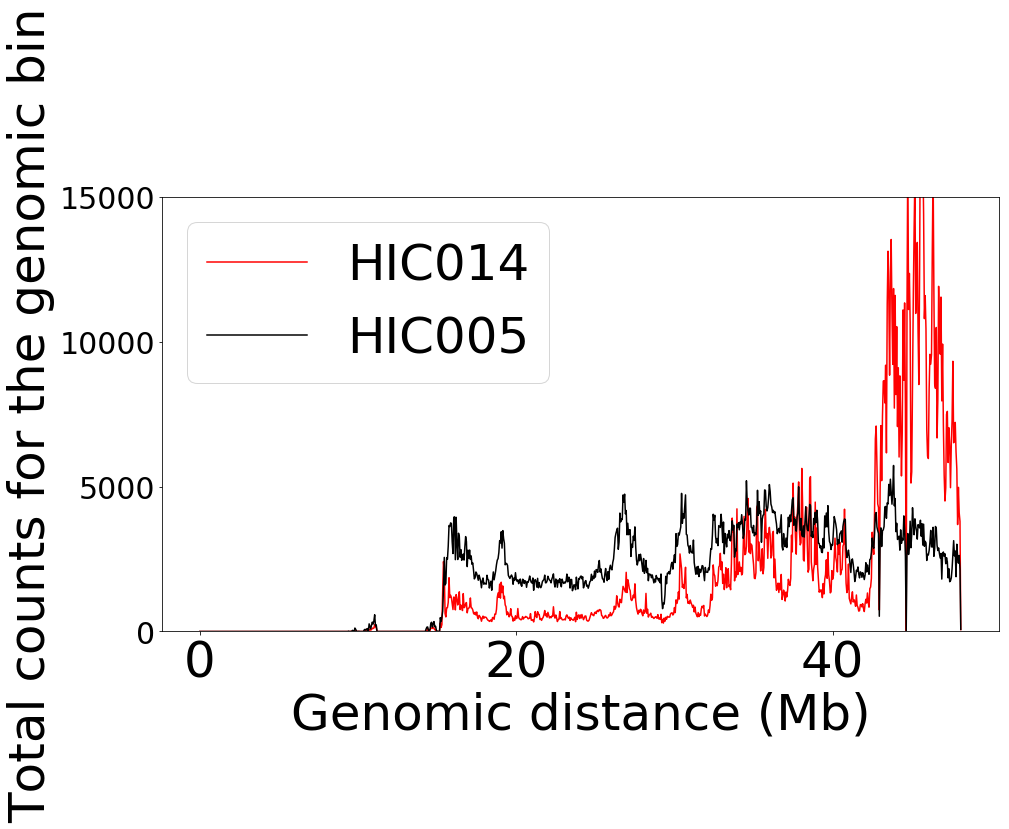

In [10]:
resolution=0.05
s=1
e=600
dds={}
ddlist={}
x=[]

figwidth=15
figheight=8
fig, plots = plt.subplots(1,1)
fig.set_size_inches(figwidth,figheight)

for mname_number in [14,5]:
    if mname_number==0:
        continue
    node_file='/ifs/scratch/oursu/paper_2017-12-20/simulations/nodes/nodes.50000.chr21.gz'
    numlength=len(str(mname_number))
    if numlength==1:
        mname='HIC00'+str(mname_number)
    if numlength==2:
        mname='HIC0'+str(mname_number)
        
    if mname=='HIC014':
        c='red'
    else:
        c='black'
    m1file='/ifs/scratch/oursu/paper_2017-12-20/results/rao/res50000.final/data/edges/'+mname+'/'+mname+'.chr21.gz'
    nodes,nodes_idx,blacklist_nodes=processing.read_nodes_from_bed(node_file,'NA')
    m=processing.construct_csr_matrix_from_data_and_nodes(m1file,nodes,blacklist_nodes,True)
    m=m+m.T
    m=m.toarray()

    plots.plot([x*resolution for x in range(m.shape[0])], m.sum(axis=1),label=mname,color=c)
    plots.legend(fontsize=50)
    plots.tick_params(labelsize=50)
    plots.set_yticklabels([0,5000,10000,15000],size=30)
    plots.set_ylim(0,15000)
    #plots.set_xticklabels([0,10,20,30,40,50],size=30)
    plots.set_xlabel('Genomic distance (Mb)',fontsize=50)
    plots.set_ylabel('Total counts for the genomic bin',fontsize=50)